In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib ipympl
import matplotlib.animation
import matplotlib as mpl
import joblib
parallel = joblib.Parallel(n_jobs = -1)

import random
from PIL import Image, ImageDraw
import cv2
import numpy as np
import pandas as pd

from tifffile import imsave, imwrite
from tqdm import tqdm

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from csbdeep.utils import Path, normalize

from tracking_utils import *

np.random.seed(42)
lbl_cmap = random_label_cmap()

# REFERENCE IMAGES FROM VIDEOS

In [ ]:
def grayscale_crop_and_resize(cap, frame, x1, y1, x2, y2, w, h):
	cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
	ret, image = cap.read()
	npImage = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
	npImage = npImage[y1:y2, x1:x2]
	return cv2.resize(npImage, (500, 500))

def get_frame(cap, frame, x1, y1, x2, y2, w, h):
	cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
	ret, image = cap.read()
	npImage = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
	alpha = Image.new('L', (w, h), 0)
	draw = ImageDraw.Draw(alpha)
	draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)
	npAlpha = np.array(alpha)
	npImage = npImage*npAlpha
	ind = np.where(npImage == 0)
	npImage[ind] = npImage[200, 200]
	npImage = npImage[y1:y2, x1:x2]
	return cv2.resize(npImage, (500, 500))

In [ ]:
save_path = './training_dataset/'
nDrops = 50

source_path_25b25r = "./data/25b25r-1.mp4" 
xmin_25b25r, ymin_25b25r, xmax_25b25r, ymax_25b25r = 95, 30, 535, 470
video_25b25r = cv2.VideoCapture(source_path_25b25r)
video_25b25r.set(cv2.CAP_PROP_POS_FRAMES, 0)
w_25b25r = int(video_25b25r.get(cv2.CAP_PROP_FRAME_WIDTH))
h_25b25r = int(video_25b25r.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps_25b25r = int(video_25b25r.get(cv2.CAP_PROP_FPS))
n_frames_25b25r = int(video_25b25r.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"25b25r video has {n_frames_25b25r} frames with a resolution of {w_25b25r}x{h_25b25r} and a framerate of {fps_25b25r} fps")


source_path_49b1r  = "./data/49b1r.mp4"
xmin_49b1r,  ymin_49b1r,  xmax_49b1r,  ymax_49b1r  = 20, 50, 900, 930
nDrops_post_merge_49b1r = 49
video_49b1r = cv2.VideoCapture(source_path_49b1r)
video_49b1r.set(cv2.CAP_PROP_POS_FRAMES, 0)
w_49b1r = int(video_49b1r.get(cv2.CAP_PROP_FRAME_WIDTH))
h_49b1r = int(video_49b1r.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps_49b1r = int(video_49b1r.get(cv2.CAP_PROP_FPS))
n_frames_49b1r = int(video_49b1r.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"49b1r video has {n_frames_49b1r} frames with a resolution of {w_49b1r}x{h_49b1r} and a framerate of {fps_49b1r} fps")
print(f"25b25r video can be cropped to : {ymax_25b25r - ymin_25b25r, xmax_25b25r - xmin_25b25r}")
print(f"49b1r  video can be cropped to : {ymax_49b1r -  ymin_49b1r,  xmax_49b1r -  xmin_49b1r }")

start_49b1r = get_frame(video_49b1r, 0, xmin_49b1r, ymin_49b1r, xmax_49b1r, ymax_49b1r, w_49b1r, h_49b1r)
end_49b1r = get_frame(video_49b1r, n_frames_49b1r-1, xmin_49b1r, ymin_49b1r, xmax_49b1r, ymax_49b1r, w_49b1r, h_49b1r)
start_25b25r = get_frame(video_25b25r, 0, xmin_25b25r, ymin_25b25r, xmax_25b25r, ymax_25b25r, w_25b25r, h_25b25r)
end_25b25r = get_frame(video_25b25r, n_frames_25b25r-1, xmin_25b25r, ymin_25b25r, xmax_25b25r, ymax_25b25r, w_25b25r, h_25b25r)

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0,0].imshow(start_49b1r, cmap='gray', vmin=0, vmax=255)
ax[0,0].set_title('Start 49b1r')
ax[0,1].imshow(end_49b1r, cmap='gray', vmin=0, vmax=255)
ax[0,1].set_title('End 49b1r')
ax[1,0].imshow(start_25b25r, cmap='gray', vmin=0, vmax=255)
ax[1,0].set_title('Start 25b25r')
ax[1,1].imshow(end_25b25r, cmap='gray', vmin=0, vmax=255)
ax[1,1].set_title('End 25b25r')
plt.tight_layout()
plt.show()


if 0:
    n_samples_49b1r  = 100
    n_samples_25b25r = 100
    n_samples = n_samples_49b1r + n_samples_25b25r

    np.random.seed(0)
    sample_frames_49b1r  = np.sort(np.array(random.sample(range(30000 ), n_samples_49b1r )), axis=0)
    sample_frames_25b25r = np.sort(np.array(random.sample(range(n_frames_25b25r), n_samples_25b25r)), axis=0)

    for frame in tqdm(sample_frames_49b1r):
        imsave(f"{save_path}49b1r/image/49b1r_frame{frame}.tif", get_frame(video_49b1r, frame, xmin_49b1r, ymin_49b1r, xmax_49b1r, ymax_49b1r, w_49b1r, h_49b1r))

    for frame in tqdm(sample_frames_25b25r):
        imsave(f"{save_path}25b25r/image/25b25r_frame{frame}.tif", get_frame(video_25b25r, frame, xmin_25b25r, ymin_25b25r, xmax_25b25r, ymax_25b25r, w_25b25r, h_25b25r))

# SYNTHETIC DATASET FROM SIMULATION

In [ ]:
def overlap_between_circles(existing_circles, center, radius):
    for existing_center in existing_circles:
        distance = np.linalg.norm(np.array(existing_center) - np.array(center))
        if distance < 2*radius:
            return True
    return False

def initial_droplet_positions(nFeatures, rFeature, rMax):
    list_of_centers = []
    for i in range(nFeatures):
        while True:
            # Generate a random position inside the outer circle 
            theta = random.uniform(0, 2 * np.pi)
            r = random.uniform(0, rMax - rFeature)
            center = (r * np.cos(theta), r * np.sin(theta))
            if not overlap_between_circles(list_of_centers, center, rFeature):
                list_of_centers.append(center)
                break
    return np.array(list_of_centers)

# Function to check for collisions between droplets
def handle_droplet_collisions(pos, droplet_radius):
    r_ij_m = np.linalg.norm(pos[:, np.newaxis] - pos, axis=2)
    mask = np.tril(r_ij_m < 2 * droplet_radius, k=-1)
    r_ij = (pos[:, np.newaxis] - pos) * mask[:, :, np.newaxis]
    # Normalize displacements
    norms = np.linalg.norm(r_ij, axis=2)
    norms[norms == 0] = 1 # Avoid division by zero
    r_ij_v = r_ij / norms[:, :, np.newaxis]
    # Calculate adjustment factor
    adjustment = (2 * droplet_radius - r_ij_m) * mask
    # Apply adjustments to positions
    pos += np.sum(r_ij_v * (adjustment / 2)[:, :, np.newaxis], axis=1)
    pos -= np.sum(r_ij_v * (adjustment / 2)[:, :, np.newaxis], axis=0)

def handle_boundary_collisions(pos, outer_radius, droplet_radius):
    distances = np.linalg.norm(pos, axis=1)
    # Find indices where distances exceed the boundary
    out_of_boundary_mask = distances > outer_radius - droplet_radius
    # Calculate adjustment factor for positions exceeding the boundary
    adjustment = (outer_radius - droplet_radius) / distances[out_of_boundary_mask]
    # Apply adjustments to positions
    pos[out_of_boundary_mask] *= adjustment[:, np.newaxis]

def short_range_align(T0, pos, orientations, align_radius):
    T = np.zeros(pos.shape[0])
    for n in range(pos.shape[0]):
        v_n = np.array([np.cos(orientations[n]), np.sin(orientations[n])])
        r_ni = pos[n] - pos[np.arange(pos.shape[0])!=n]
        r_i = np.linalg.norm(r_ni, axis=1)
        S = np.where(r_i < align_radius)[0]
        T[n] = T0 * np.sum(np.divide(np.sum(v_n*r_ni[S], axis = 1), r_i[S]**2) *\
                            np.cross(np.array([np.cos(orientations[n]), np.sin(orientations[n])]), r_ni[S]))
    return T

def handle_boundary_repulsion(pos, repulsion_radius, repulsion_strength, dt):    
    distances = np.linalg.norm(pos, axis = 1) 
    boundary_indices = distances > outer_radius - repulsion_radius
    if np.any(boundary_indices):
        # Calculate repulsion force direction
        directions = - pos / distances[:, np.newaxis]
        forces = repulsion_strength / ((outer_radius - distances) ** 2)[:, np.newaxis]
        pos[boundary_indices] += forces[boundary_indices] * directions[boundary_indices] * dt

def lj_interaction(pos, epsilon, sigma, dt):
    r_ij = pos[:, np.newaxis] - pos
    r_ij_m = np.linalg.norm(r_ij, axis=2)
    directions = r_ij / r_ij_m[:, :, np.newaxis]
    directions[np.isnan(directions)] = 0
    lj_force = 4 * epsilon * (12 * sigma**12 / r_ij_m**13 - 6 * sigma**6 / r_ij_m**7)
    lj_force[np.isnan(lj_force)] = 0
    forces = np.sum(lj_force[:, :, np.newaxis] * directions, axis=1)
    pos += forces * dt

In [ ]:
# SETUP
np.random.seed(0)

num_droplets = 50
time_steps = 10000
dt = 0.1 # time step size
droplet_radius = 10 # radius of the droplets
outer_radius = 250
v0_init = 10 # magnitude of the self-propulsion velocity
time_constant = time_steps # time constant for the exponential decay of the self-propulsion velocity

D_r = .1 # rotational diffusion coefficient
D_t = .1 # translational diffusion coefficient

T0 = 10 # magnitude of the short-range alignment force
align_radius = 7*droplet_radius  # radius for short-range alignment

repulsion_radius = outer_radius #50
repulsion_strength = 5*10**3
# parameters for the Lennard-Jones potential
epsilon = 2
sigma = 2*droplet_radius


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(range(time_steps), v0_init * np.exp(-np.array(range(time_steps)) / time_constant))
plt.savefig('./simulation/self_propulsion_velocity_decay.png')
plt.close()

test_pos = initial_droplet_positions(nFeatures = num_droplets, rFeature = droplet_radius, rMax = outer_radius - 30)
distances = np.linalg.norm(test_pos, axis=1)
boundary_indices = distances > outer_radius - repulsion_radius
if np.any(boundary_indices):
    directions = - test_pos / distances[:, np.newaxis]
    forces = repulsion_strength / ((outer_radius - distances) ** 2)[:, np.newaxis]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(num_droplets):
    if boundary_indices[i]:
        ax.add_artist(plt.Circle((test_pos[i, 0], test_pos[i, 1]), droplet_radius, color='r', fill=True, alpha=0.5))
    else:
        ax.add_artist(plt.Circle((test_pos[i, 0], test_pos[i, 1]), droplet_radius, color='r', fill=False))
ax.add_artist(plt.Circle((0, 0), outer_radius, color='b', fill=False))
ax.quiver(test_pos[boundary_indices, 0], test_pos[boundary_indices, 1], (forces * directions)[boundary_indices, 0], (forces * directions)[boundary_indices, 1])
ax.add_artist(plt.Circle((0, 0), outer_radius - repulsion_radius, color='b', fill=False))
ax.set_xlim(-outer_radius , outer_radius)
ax.set_ylim(-outer_radius, outer_radius)
plt.savefig('./simulation/initial_droplet_positions.png', dpi = 300)
plt.close()


r_ij = test_pos[:, np.newaxis] - test_pos
r_ij_m = np.linalg.norm(r_ij, axis=2)
directions = r_ij / r_ij_m[:, :, np.newaxis]
directions[np.isnan(directions)] = 0
lj_force = 4 * epsilon * (12 * sigma**12 / r_ij_m**13 - 6 * sigma**6 / r_ij_m**7)
lj_force[np.isnan(lj_force)] = 0
forces = np.sum(lj_force[:, :, np.newaxis] * directions, axis=1)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
for i in range(num_droplets):
    ax.add_artist(plt.Circle((test_pos[i, 0], test_pos[i, 1]), droplet_radius, color='r', fill=False))
ax.quiver(test_pos[:, 0], test_pos[:, 1], forces[:, 0], forces[:, 1], color='r')
ax.set_xlim(-outer_radius, outer_radius)
ax.set_ylim(-outer_radius, outer_radius)
for i in range(num_droplets):
    ax1.add_artist(plt.Circle((test_pos[i, 0] + forces[i, 0]*dt, test_pos[i, 1] + forces[i, 1]*dt), droplet_radius, color='r', fill=False))
plt.show()

In [ ]:
if 1:
    # Initialize droplet positions and orientations
    positions = initial_droplet_positions(nFeatures = num_droplets, rFeature = droplet_radius, rMax = outer_radius)
    orientations = np.random.uniform(0, 2*np.pi, size = num_droplets)

    frames, x, y, r, label = [], [], [], [], []

    for step in tqdm(range(time_steps)):
        # update magnitude of self-propulsion velocity
        v0 = v0_init * np.exp(-step / time_constant)
        # Update positions
        positions += v0 * np.array([np.cos(orientations), np.sin(orientations)]).T * dt + \
                        np.random.normal(scale=np.sqrt(2 * D_t * dt), size=(num_droplets, 2))

        # Handle collisions with the boundary and between droplets
        handle_droplet_collisions(pos = positions, droplet_radius = droplet_radius)
        #handle_boundary_collisions(pos = positions, outer_radius = outer_radius, droplet_radius = droplet_radius) 
        handle_boundary_repulsion(pos = positions, repulsion_radius = repulsion_radius, repulsion_strength = repulsion_strength, dt = dt)
        lj_interaction(pos = positions, epsilon = epsilon, sigma = sigma, dt = dt)
        
        # Update orientations with rotational diffusion and short-range alignment
        short_range_align(T0, positions, orientations, align_radius)
        orientations += np.random.normal(scale=np.sqrt(2 * D_r * dt), size=num_droplets)

        # Ensure orientations stay within [0, 2*pi)
        orientations %= 2 * np.pi

        frames += [step for i in range(num_droplets)]
        x += list(positions[:, 0])
        y += list(positions[:, 1])
        r += [droplet_radius for i in range(num_droplets)]
        label += [i for i in range(num_droplets)]
        
    trajectories = pd.DataFrame({'frame': frames, 'x': x, 'y': y, 'r': r, 'label': label})
    trajectories.to_parquet('./simulation/trajectories_simulate_test.parquet')
else:
    trajectories = pd.read_parquet('./simulation/trajectories_simulate_test.parquet')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True
        
def update_graph(frame):
    df = trajectories.loc[(trajectories.frame == frame), ["x", "y", "r"]]
    for i in range(len(df)):
        graph[i].center = (df.x.values[i], df.y.values[i])
        graph[i].radius = df.r.values[i]
    title.set_text(f'Tracking -- step = {frame} ')
    return graph

title = ax.set_title(f'Tracking -- step = {0} ')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]')
df = trajectories.loc[(trajectories.frame == 0), ["x", "y", "r"]]

graph = []
for i in range(len(df)):
    graph.append(ax.add_artist(plt.Circle((df.x.values[i], df.y.values[i]), df.r.values[i], fill = True, alpha = 0.5, color = 'b')))
ax.add_artist(plt.Circle((0, 0), outer_radius, color='r', fill=False))
ax.set_xlim(-outer_radius, outer_radius)
ax.set_ylim(-outer_radius, outer_radius)

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, range(time_steps), interval = 5, blit = False)
writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args = ['-vcodec', 'libx264'])
ani.save(f'./simulation/test.mp4', writer = writer)
plt.close()

In [ ]:
from yupi import Trajectory, WindowType, DiffMethod
import yupi.graphics as yg
import yupi.stats as ys


trajectories = pd.read_parquet('./simulation/trajectories_simulate_test.parquet')
trajectories2 = trajectories.copy()
trajectories2.rename(columns = {'label': 'particle'}, inplace = True)
trajs = []
for i in range(num_droplets):
    p = trajectories2.loc[trajectories2.particle == i, ["x", "y"]]
    trajs.append(Trajectory(p.x, p.y, dt = 1, traj_id=i, diff_est={"method":DiffMethod.LINEAR_DIFF, 
                                                                            "window_type": WindowType.CENTRAL}))

v_norm = ys.speed_ensemble(trajs)
theta = ys.turning_angles_ensemble(trajs, centered = True)
msd, msd_std = ys.msd(trajs, time_avg=True, lag=1000)
vacf, _ = ys.vacf(trajs, time_avg=True, lag=1000)

fig, axs = plt.subplots(2, 2, figsize = (10, 6))
axs[0, 0].hist(v_norm, bins = 100, color = 'b', alpha = 0.5, density= True)
axs[0, 0].set(xlim = (0, 5), title = 'Speed distribution')
axs[0, 1].hist(theta, bins = 100, color = 'r', alpha = 0.5, density= True)
axs[0, 1].set(xlim = (-np.pi, np.pi), title = 'Turning angle distribution')
axs[1, 0].plot(msd, label = 'MSD')
axs[1, 0].fill_between(range(len(msd)), msd - msd_std, msd + msd_std, alpha = 0.5)
axs[1, 0].axvline(x = 1/D_r, color = 'r', linestyle = '--')
axs[1, 0].set(title = 'MSD', xscale = 'log', yscale = 'log')
axs[1, 1].plot(vacf, label = 'VACF')
axs[1, 1].set(title = 'VACF')
axs[0, 0].grid()
axs[0, 1].grid()
axs[1, 0].grid()
axs[1, 1].grid()
plt.tight_layout()
plt.show()

# SYNTHETIC DATASET GENERATOR

In [ ]:
source_path_25b25r = "./data/25b25r-1.mp4" 
xmin_25b25r, ymin_25b25r, xmax_25b25r, ymax_25b25r = 95, 30, 535, 470
video_25b25r = cv2.VideoCapture(source_path_25b25r)
video_25b25r.set(cv2.CAP_PROP_POS_FRAMES, 0)
w_25b25r = int(video_25b25r.get(cv2.CAP_PROP_FRAME_WIDTH))
h_25b25r = int(video_25b25r.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps_25b25r = int(video_25b25r.get(cv2.CAP_PROP_FPS))
n_frames_25b25r = int(video_25b25r.get(cv2.CAP_PROP_FRAME_COUNT))


source_path_49b1r  = "./data/49b1r.mp4"
xmin_49b1r,  ymin_49b1r,  xmax_49b1r,  ymax_49b1r  = 20, 50, 900, 930
video_49b1r = cv2.VideoCapture(source_path_49b1r)
video_49b1r.set(cv2.CAP_PROP_POS_FRAMES, 0)
w_49b1r = int(video_49b1r.get(cv2.CAP_PROP_FRAME_WIDTH))
h_49b1r = int(video_49b1r.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps_49b1r = int(video_49b1r.get(cv2.CAP_PROP_FPS))
n_frames_49b1r = int(video_49b1r.get(cv2.CAP_PROP_FRAME_COUNT))

start_49b1r = get_frame(video_49b1r, 0, xmin_49b1r, ymin_49b1r, xmax_49b1r, ymax_49b1r, w_49b1r, h_49b1r, False)
end_49b1r = get_frame(video_49b1r, n_frames_49b1r-1, xmin_49b1r, ymin_49b1r, xmax_49b1r, ymax_49b1r, w_49b1r, h_49b1r, False)
start_25b25r = get_frame(video_25b25r, 0, xmin_25b25r, ymin_25b25r, xmax_25b25r, ymax_25b25r, w_25b25r, h_25b25r, False)
end_25b25r = get_frame(video_25b25r, n_frames_25b25r-1, xmin_25b25r, ymin_25b25r, xmax_25b25r, ymax_25b25r, w_25b25r, h_25b25r, False)

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0,0].imshow(start_49b1r, cmap='gray', vmin=0, vmax=255)
ax[0,0].set_title('Start 49b1r')
ax[0,1].imshow(end_49b1r, cmap='gray', vmin=0, vmax=255)
ax[0,1].set_title('End 49b1r')
ax[1,0].imshow(start_25b25r, cmap='gray', vmin=0, vmax=255)
ax[1,0].set_title('Start 25b25r')
ax[1,1].imshow(end_25b25r, cmap='gray', vmin=0, vmax=255)
ax[1,1].set_title('End 25b25r')
plt.tight_layout()
plt.show()

(500, 500) (500, 500) (500, 500)


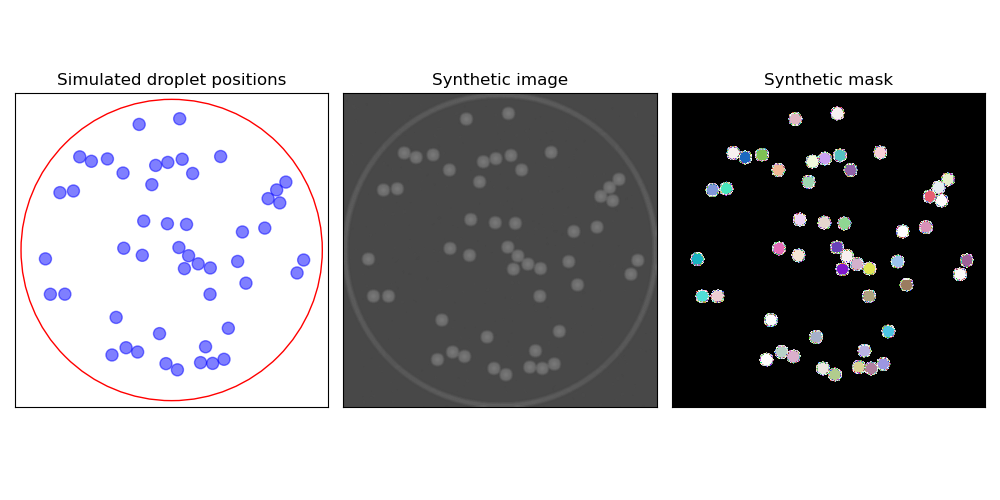

In [21]:
if 0:
    test_img, test_mask = generate_synthetic_image(outer_radius=100, n_feature=50, height=500,\
                                               width=500, rmin=10, rmax=10, color=110, gaussian_sigma=20,\
                                               gaussian_amplitude=10, sharp_verb=True) 

test_frame = 5000
trajectories = pd.read_parquet('./simulation/trajectories_simulate_test.parquet')
test_img, test_mask, circles_array = zip(*parallel(generate_synthetic_image_from_simulation_data_parallel(trajectories=trajectories,\
                                                                        frame=test_frame, height=500, width=500, gaussian_sigma=5,\
                                                                        gaussian_amplitude=20, color=100, sharp_verb=True) for frame in range(1)))
test_img = test_img[0]
test_mask = test_mask[0]
circles_array = circles_array[0]

temp = trajectories.loc[(trajectories.frame == test_frame), ["x", "y", "r"]]
fig, ax = plt.subplots(1, 3, figsize = (10, 5))
for i in range(len(temp)):
    ax[0].add_artist(plt.Circle((temp.x.values[i], temp.y.values[i]), temp.r.values[i], fill = True, alpha = 0.5, color = 'b'))
ax[0].add_artist(plt.Circle((0, 0), 250, color='r', fill=False))
ax[0].set_xlim(-260, 260)
ax[0].set_ylim(260, -260)
ax[1].imshow(test_img, cmap="gray", vmin=0, vmax=255)
ax[2].imshow(test_mask, cmap=lbl_cmap)
ax[0].set_aspect('equal')
ax[0].set(xticks=[], yticks=[], title='Simulated droplet positions')
ax[1].set(xticks=[], yticks=[], title='Synthetic image')
ax[2].set(xticks=[], yticks=[], title='Synthetic mask')
plt.tight_layout()
plt.savefig('./simulation/synthetic_image_from_simulation.png', dpi = 300)
plt.show()

if 0:
    fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=True)
    axs[0,0].imshow(test_img, cmap="gray", vmin=0, vmax=255)
    axs[0,1].imshow(start_49b1r, cmap='gray', vmin=0, vmax=255)
    axs[0,2].imshow(start_25b25r, cmap='gray', vmin=0, vmax=255)
    axs[1,0].imshow(test_mask, cmap=lbl_cmap)
    axs[1,1].imshow(end_49b1r, cmap='gray', vmin=0, vmax=255)
    axs[1,2].imshow(end_25b25r, cmap='gray', vmin=0, vmax=255)
    #axs[1,0].hist(test_img.flatten(), bins=256, range=(0, 255), density=True)
    #axs[1,1].hist(start_49b1r.flatten(), bins=256, range=(0, 255), density=True)
    #axs[1,2].hist(start_25b25r.flatten(), bins=256, range=(0, 255), density=True)
    plt.tight_layout()
    plt.show()

In [ ]:
sample_frames = trajectories.frame.unique()
test = parallel(
                generate_synthetic_image_from_simulation_data_parallel(trajectories=trajectories,\
                                                            frame=frame, height=500, width=500, gaussian_sigma=5,\
                                                            gaussian_amplitude=20, color=100, sharp_verb=True)
                for frame in tqdm(sample_frames)
)

test_img = np.array([i[0] for i in test])
test_mask = np.array([i[1] for i in test])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
def update_graph(frame):
    graph.set_data(test_img[frame])
    title.set_text(f'Simulation -- frame = {sample_frames[frame]}')
    return graph

title = ax.set_title(f'Simulation -- frame = {0}')
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]')
graph = ax.imshow(test_img[0], cmap='gray', vmin=0, vmax=255)

ani = matplotlib.animation.FuncAnimation(fig, update_graph, range(test_img.shape[0]), interval = 5, blit=False)
writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args=['-vcodec', 'libx264'])
ani.save(f'./simulation/simulation_video.mp4', writer=writer)
plt.close()

In [ ]:
for i in tqdm(range(test_img.shape[0])):
    imwrite(f'./simulation/synthetic_dataset/image/synthetic_{i}.tif', test_img[i])
    imwrite(f'./simulation/synthetic_dataset/mask/synthetic_{i}.tif', test_mask[i])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_aug, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Augmented Image')
ax[1].imshow(lbl_aug, cmap='gray')
ax[1].set_title('Augmented Mask')
plt.tight_layout()
plt.show()

# HOUGH-CIRCLE DATASET GENERATOR

## FROM DATA OF 49b-1r HOUGH CIRCLE METHOD DETECTION

In [ ]:
def get_frame(cap, frame, x1, y1, x2, y2, w, h, preprocess):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
    ret, image = cap.read()
    if preprocess:
        npImage = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        alpha = Image.new('L', (w, h), 0)
        draw = ImageDraw.Draw(alpha)
        draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)
        npAlpha = np.array(alpha)
        npImage = npImage*npAlpha
        ind = np.where(npImage == 0)
        npImage[ind] = npImage[200, 200]
        npImage = npImage[y1:y2, x1:x2]
        return npImage
    elif not preprocess:
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        raise ValueError("preprocess must be a boolean")

In [ ]:
trajectories = pd.read_parquet('./49b_1r/old/tracking_data/hough/tracking_hough_trackpy_linking.parquet')
# rename column to be consistent with the other datasets
trajectories.rename(columns={'d':'r'}, inplace=True)
# remove rows with NaN values in the radius column
trajectories.dropna(subset=['r'], inplace=True)
display(trajectories.head())

In [ ]:
video = cv2.VideoCapture('/Users/matteoscandola/MasterThesis/tracking/data/49b1r.mp4')
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
_, first_frame = video.read()

In [ ]:
# sample x frames from the hough-method tracking dataset
n_samples = 1000
np.random.seed(42)
sample_frames = np.sort(np.random.choice(trajectories.frame.unique().astype(int), size=n_samples, replace=False))

for frame in tqdm(sample_frames):
    frame_img = get_frame(video, frame, 55, 55, 880, 880, 920, 960, True)
    imsave(f"/Users/matteoscandola/MasterThesis/tracking/train_49b-1r/image/49b1r_frame{frame}.tif", frame_img)
    df = trajectories.loc[(trajectories.frame == frame), ["x", "y", "r"]]
    image = np.zeros((880 - 55, 880 - 55), dtype=np.uint8)
    count = 0
    for _, droplet in df.iterrows():
        x, y, radius = droplet['x'], droplet['y'], droplet['r']
        cv2.circle(image, (int(x)- 55, int(y) - 55), int(radius), int(count), thickness=-1)
        count += 1
    imsave(f"/Users/matteoscandola/MasterThesis/tracking/train_49b-1r/mask/49b1r_frame{frame}.tif", image)    

## GENERATING NEW HOUGH CIRCLE DETECTIONS

In [ ]:
def get_frame_hough(cap, frame, x1, y1, x2, y2, w, h):
	cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
	ret, image = cap.read()
	npImage = np.array(image)
	alpha = Image.new('L', (w, h), 0)
	draw = ImageDraw.Draw(alpha)
	draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)
	npAlpha = np.array(alpha)
	npImage = cv2.cvtColor(npImage, cv2.COLOR_BGR2GRAY)*npAlpha 
	ind = np.where(npImage == 0)
	npImage[ind] = npImage[200, 200]
	npImage = npImage[y1:y2, x1:x2]
	return npImage 
	
def hough_loc_frame(correct_n, frame, img, parameters):
	found_circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT, **parameters)
	if found_circles is not None:
		return np.hstack((found_circles[0], (np.ones((found_circles.shape[1], 1), dtype=int)*frame),\
							np.ones((found_circles.shape[1], 1), dtype=int)*found_circles.shape[1]))
	else:
		return np.hstack((np.ones((1, 3))*-1, np.array([[frame, 0]])))
		
def hough_feature_location(sample_frames, correct_n, params):
	temp = []
	for frame in tqdm(sample_frames):
		img = get_frame_hough(video, frame, xmin, ymin, xmax, ymax, w, h)
		temp.append(hough_loc_frame(correct_n, frame, img, params))
	
	temp_df = pd.DataFrame(np.concatenate([arr for arr in temp]), columns = ["x", "y", "d", "frame", "nDroplets"])
	temp_df["frame"] = temp_df["frame"].astype(int)
	temp_df["nDroplets"] = temp_df["nDroplets"].astype(int)
	err_frames = temp_df.loc[temp_df.nDroplets != correct_n].frame.unique().astype(int)
	loss = err_frames.shape[0]/sample_frames.shape[0]
	return temp_df, err_frames, loss

def optimize_params(x, *args):
	frames, correct_n = args
	params = {"dp":x[0], "minDist":int(x[1]), "param1":x[2], "param2":x[3], "minRadius":int(x[4]), "maxRadius":int(x[5])}
	errs = 0
	for i in tqdm(frames):
		img = get_frame_hough(video, i, xmin, ymin, xmax, ymax, w, h)
		found_circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT, **params)
		if (found_circles is not None) and (found_circles.shape[1] == correct_n):
			pass
		else:
			errs += 1
			
	loss = errs/frames.shape[0]
	a = [loss, x[0], int(x[1]), x[2], x[3], int(x[4]), int(x[5])]
	print(a)
	return loss

In [ ]:
n_samples = 100
random.seed(0)
sample_frames = np.sort(np.array(random.sample(range(n_frames), n_samples)), axis=0)

test_params = {"dp":1.5, "minDist":10, "param1":20, "param2":0.7, "minRadius":5, "maxRadius":30}

temp_df, err_frames, loss = hough_feature_location(sample_frames, nDrops, test_params)
print(loss, err_frames)
temp_df_test = temp_df.loc[temp_df.frame == err_frames[1]]
test_img = get_frame_hough(video, err_frames[1], xmin, ymin, xmax, ymax, w, h)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(test_img, cmap="gray")
for i in range(temp_df_test.nDroplets.iloc[0]):
    circle = plt.Circle((temp_df_test.x.iloc[i], temp_df_test.y.iloc[i]), temp_df_test.d.iloc[i], color='r', fill=True, alpha=0.5)
    ax.add_artist(circle)
ax.set(xticks=[], yticks=[], title=f"Frame {err_frames[1]} -- {temp_df_test.nDroplets.iloc[0]} droplets")
plt.show()

In [ ]:
# paramters of HoughCircles --> dp, minDist, param1, param2, minRadius, maxRadius
init_guess =  [2, 5, 20, 0.7, 7, 12] # initial guess for the parameters
params_bounds = [(1, 3), (1, 10), (1, 100), (0.3, 1), (5, 10), (10, 15)] # bounds for the parameters

opt_result = dual_annealing(optimize_params, x0 = init_guess, args = (sample_frames, nDrops), bounds = params_bounds, maxiter = 2000)